In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import nibabel as nib
import scipy.io
import time
import pandas as pd
import glob
import re
import os
import scipy.ndimage
import scipy.linalg
from pathlib import Path

from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product

In [36]:
import h5py

with h5py.File('AllMaps.mat', 'r') as f:
    title_refs  = f['AllMaps']['Metabos']['Title'][0]
    #print(list(normal_group.keys()))
    
    Metabos = f['AllMaps']['Metabos']['Normal'][:]

import h5py

with h5py.File('AllMaps.mat', 'r') as f:
    title_refs = f['AllMaps']['Metabos']['Title'][0]

    metabolite_names = []
    for ref in title_refs:
        data = f[ref][()]
        if isinstance(data, np.ndarray):
            metabolite_names.append(bytes(data[0]).decode('utf-8'))
        else:
            metabolite_names.append(data.decode('utf-8'))

    print(metabolite_names)



['G\x00', 'A\x00', 'C\x00', 'G\x00', 'G\x00', 'G\x00', 'G\x00', 'I\x00', 'M\x00', 'M\x00', 'M\x00', 'M\x00', 'M\x00', 'M\x00', 'M\x00', 'M\x00', 'M\x00', 'N\x00', 'N\x00', 'P\x00', 'P\x00', 'S\x00', 'T\x00', 'T\x00', 'G\x00', 'L\x00', 'G\x00', 'N\x00', 'C\x00', 'G\x00']


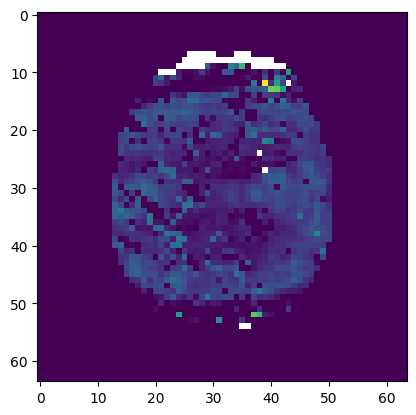

In [37]:
Metabo = 24
z = 15

Slice = Metabos[Metabo, z, :, :]

plt.imshow(Slice)

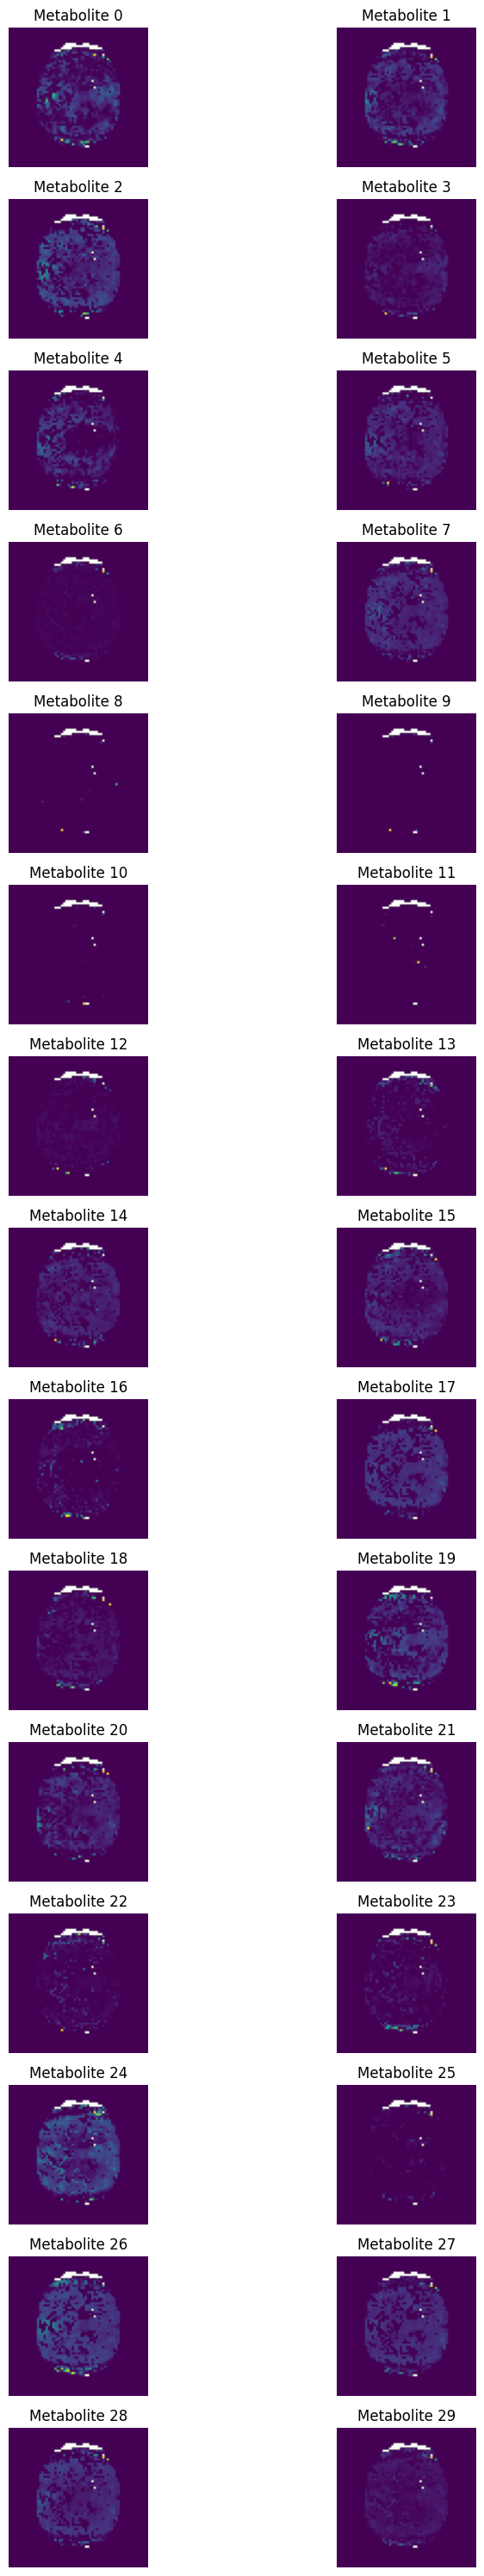

In [23]:
Metabo = 3
z = 15

fig, axs = plt.subplots(15, 2, figsize=(10, 30))  # 15 rows, 2 columns

for i in range(30):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.imshow(Metabos[i, z, :, :], cmap='viridis')
    ax.set_title(f'Metabolite {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [2]:
#Notes:
# v1 Test
# v2 Test
# v3 First Dataset

version='v_1.0'
path = 'data/'

#subjects = ['/3DMRSIMAP_Vol_04_A_1_2024-09-06_L2_0p0005', '3DMRSIMAP_Vol_08_A_1_2024-09-07_L2_0p0005'] #'3DMRSIMAP_Vol_10_A_1_2024-09-04_L2_0p0005','3DMRSIMAP_Vol_16_A_1_2024-09-05_L2_0p0005'
subjects = ['Vol6']

# Water Removal
b_RemWat = True
WatSuppComp = 32 # Number of component for the HSVD water removal (advised: 16 at 3T and 32 at 7T)
minFreq = -150 # -150Hz(7T) # +-0.5ppm
maxFreq = 150 # 150
parallel_jobs = 20

bandwidth = 2778 # Vienna: 2778 Paul: 3000
dwell_time = 1/bandwidth # Vienna 360000 nano seconds = 3.6*10⁻4 seconds

# Simulation
nSpectra=20
nRandomLipid=10
MaxLipidScaling=70

MaxSNR=10
MinSNR=1

N= 840 # This is FID length. Vienna: 840, Paul: 960
NMRFreq= 297222931.0 # (Lamor frequeny) Vienna : 297222931, Paul: 297189866
sampling_rate = 1/dwell_time  # Hz  sampling_rate = 1/dwell_time

MaxAcquDelay=0.002
MaxFreq_Shift = 40 #shifts peak
MinPeak_Width=20#4 damping factor 
MaxPeak_Width=100#20


sub = 'Vol6'
p_mask= path + sub + '/masks/brain_mask.npy'
p_cc = path + sub + '/OriginalData/data.npy' # coil combined reconstructed data
p_scalp_mask = path + sub + '/masks/lipid_mask.npy'
p_save = path + sub + '/OriginalData/'

#####################
##### Load Data #####
#####################

brainmask = np.load(p_mask)  #Hauke: That should be the brain mask

csi_rrrt = np.load(p_cc)

skmask = np.load(p_scalp_mask)  # scalp mask / lipid mask

headmask = brainmask + skmask

#########################
##### Water Removal #####
#########################

water_rrrt=np.load(p_save + 'IsolatedWater.npy')
image_rrrt=np.load(p_save + 'SupressedWater.npy')

In [3]:
#####################################
##### Lipid Projection Operator #####
#####################################

#imagesl_rrrt = image_rrrt[:,:,20,None]
#skmasksl = skmask[:,:,20,None]

Data_rrrf = np.fft.fftshift(np.fft.fft(csi_rrrt, axis=-1), axes=-1) # use water unsupressed data, for wallinet
#Data_rrrf = np.fft.fftshift(np.fft.fft(image_rrrt, axis=-1), axes=-1) # use water supressed data, for lipnet
#Data_rrrf = np.fft.fftshift(np.fft.fft(imagesl_rrrt, axis=-1), axes=-1) # use water supressed data, just one slice for testing

s = Data_rrrf.shape
beta=1E-5 * 3 #beta=1E-24 * 3 #0.938
multBeta = 1.5
lipidFac = 0
LipidTarget = 0.938# 0.938 Paul 0.995
lower=None

Data_rf = np.reshape(Data_rrrf, (s[0]*s[1]*s[2],s[3]))
lipid_mask = np.reshape(skmask, (s[0]*s[1]*s[2]))
#lipid_mask = np.reshape(skmasksl, (s[0]*s[1]*s[2]))

lipid_rf = Data_rf[lipid_mask>0,:]

print("lipid_rf shape:", lipid_rf.shape)
print("total lipid energy:", np.sum(np.abs(lipid_rf)))

while np.abs(lipidFac-LipidTarget) > 0.005:
    print(lipidFac)
    LipidRem_Operator_ff = np.linalg.inv(np.eye(s[-1]) + beta * np.matmul(np.conj(lipid_rf).T, lipid_rf))
    ## Mean vlaue of diagonal should be 1 or above 0.9
    ## 
    #print("Mean Absolute Value of Diagonal of Lipid Suppression Operator: ")
    lipidFac = np.mean(np.abs(np.diagonal(LipidRem_Operator_ff)))
    #print(lipidFac)
    

    if lipidFac < LipidTarget:
        beta = beta/multBeta
        if lower==False:
            multBeta=0.5*multBeta
        lower=True
    else:
        beta = beta*multBeta
        if lower==True:
            multBeta=0.5*multBeta
        lower=False

print("Mean Absolute Value of Diagonal of Lipid Suppression Operator: " + str(lipidFac))
LipidRem_Operator_ff = np.linalg.inv(np.eye(s[-1]) + beta * np.matmul(np.conj(lipid_rf).T, lipid_rf))
LipidProj_Operator_ff = np.eye(LipidRem_Operator_ff.shape[0]) - LipidRem_Operator_ff



#################################
##### Metabolite Simulation #####
#################################

# Calculate the time vector
t = np.arange(N) / sampling_rate

# Simulation parameters
AcquDelay = (np.random.rand(nSpectra, 1)-0.5)*2 * MaxAcquDelay

PhShift=np.random.rand(nSpectra, 1) * 2 * np.pi
TimeSerieClean = np.zeros(( N), dtype=np.complex64)

FreqShift = (np.random.rand(nSpectra, 1)*2 - 1) * MaxFreq_Shift

PeakWidth = MinPeak_Width + np.random.rand(nSpectra, 1) * (MaxPeak_Width - MinPeak_Width)
ponder_peaks = np.random.rand(nSpectra, 1)
PeakWidth_Gau = np.multiply(ponder_peaks, PeakWidth)
PeakWidth_Lor = np.multiply(1-ponder_peaks, PeakWidth)

SNR = MinSNR + np.random.rand(nSpectra, 1) * (MaxSNR - MinSNR)



########################################
#### Perpare metabolite information ####
########################################
def ReadModeFiles(index,list_file):
    NbM = len(list_file)
    temp_modes = [None] * NbM  # empty list of size NbM 
    for i, filename in enumerate(list_file):
        metabo_mode = pd.read_csv(filename, header=None, skiprows=[0]).values
        m = re.search("[0-9]T_.{1,6}_Exact", filename)
        name = bytes(filename[m.span()[0]+3:m.span()[1]-6].strip(), 'utf8')
        temp_modes[index[name]] = metabo_mode
    return temp_modes

index = {}  # mapping of metabolite name to index
mean_std_csv = pd.read_csv('MetabModes/Metab_Mean_STD.txt', header=None).values

for i, v in enumerate(mean_std_csv[:, 0].astype(str)):
    index[ bytes(v.strip(), 'utf8') ] = i

mean_std = mean_std_csv[:, 1:].astype(np.float32)

list_file = glob.glob('MetabModes/7T_TE0/*Exact_Modes.txt')
NbM = len(list_file)
metabo_modes = [[[None] for j in range(NbM)] for i in range(6)]
temp_modes = ReadModeFiles(index,list_file)
metabo_modes[0]=temp_modes

# Metabolic parameters
TempMetabData = np.zeros( (len(metabo_modes[0]), N), dtype=np.complex64)
BasisI = 0#np.floor(np.random.rand(nSpectra, 1) * 6)

Amplitude = mean_std[:, 1]* np.random.randn(nSpectra, NbM) + mean_std[:, 0]
Amplitude = Amplitude.clip(min=0)


#############################
#### Simulate metabolite ####
#############################
MetabSpectrum = np.zeros((nSpectra, N), dtype=np.complex128)
for n in tqdm(range(nSpectra)):

    TempMetabData =0*TempMetabData
    for f, mode in enumerate(metabo_modes[0]):   # metabo_modes[int(BasisI[n])]
            Freq = ((4.7-mode[:, 0]) * 1e-6 * NMRFreq)[...,None]

            for Nuc in range(len(Freq)):
                if (mode[Nuc, 0] > 0.0) & (mode[Nuc, 0] < 4.5)  : # only for the window of interest 
                    TempMetabData[f, :] += mode[Nuc, 1][...,None] * np.exp(1j * mode[Nuc, 2][...,None]) * np.exp(2 * np.pi * 1j * (t + AcquDelay[n])  * (Freq[Nuc]))

    TimeSerieClean=0*TimeSerieClean
    for f, _ in enumerate(metabo_modes[0]):  # metabo_modes[int(BasisI[ex])]
        TimeSerieClean[:] += Amplitude[n, f] * TempMetabData[f, :]* np.exp(1j * PhShift[n])  

    TimeSerieClean[:] *= np.exp( (t* 1j * 2 * np.pi * FreqShift[n] ) + (- (np.square(t)) * (np.square(PeakWidth_Gau[n]))) + ((np.absolute(t)) * (- PeakWidth_Lor[n]) ) )
    SpectrumTemp = np.fft.fftshift(np.fft.fft(TimeSerieClean[:],axis=0))

    # SNR
    NCRand=(np.random.randn(N) + 1j * np.random.randn(N))
    TimeSerie = TimeSerieClean + np.fft.ifft(SpectrumTemp.std()/0.65 / SNR[n] * NCRand,axis=0)

    MetabSpectrum[n] = np.fft.fftshift(np.fft.fft(TimeSerie))

############################
##### Lipid Simulation #####
############################

lipid_rf = np.zeros((nSpectra, N), dtype=np.complex64)
image_rrrf = np.fft.fftshift(np.fft.fft(image_rrrt,axis=-1),axes=-1)

for i in range(nSpectra):
    
    indices = np.random.choice(range(int(np.sum(skmask))), size=nRandomLipid)
    nonzero_indices = np.nonzero(skmask)
    xx = nonzero_indices[0][indices]
    yy = nonzero_indices[1][indices]
    zz = nonzero_indices[2][indices]
    
    lipid_batch = image_rrrf[xx,yy,zz,:]
    
    
    LipAmp = np.random.rand(nRandomLipid)
    LipAmp=LipAmp/np.sum(LipAmp)
    LipidPh= 2 * np.pi * np.random.rand(nRandomLipid)
    
    lipid_rf[i] = np.sum(lipid_batch * LipAmp[:,None], axis=0) #*np.exp(1j * LipidPh[:,None])


Lip_max = np.amax(np.abs(lipid_rf), axis=1)[:,None]
Metab_max = np.amax(np.abs(MetabSpectrum), axis=1)[:,None]
LipidScaling = 1e-1*(10**(np.random.rand(nSpectra, 1)*np.log10(1e1*MaxLipidScaling)))  
lipid_rf =  Metab_max/Lip_max*LipidScaling * lipid_rf


############################
##### Water Simulation #####
############################

water_rf = np.zeros((nSpectra, N), dtype=np.complex64)
water_rrrf = np.fft.fftshift(np.fft.fft(water_rrrt,axis=-1),axes=-1)

for i in range(nSpectra):
    
    indices = np.random.choice(range(int(np.sum(brainmask))), size=1)
    nonzero_indices = np.nonzero(brainmask)
    xx = nonzero_indices[0][indices]
    yy = nonzero_indices[1][indices]
    zz = nonzero_indices[2][indices]
    
    water_batch = water_rrrf[xx,yy,zz,:]
    
    WatAmp = np.random.rand(1)+.5
    #print(water_batch.shape)
    #print(WatAmp.shape)
    water_rf[i] = np.sum(water_batch * WatAmp[:,None], axis=0)

Wat_max = np.amax(np.abs(water_rf), axis=1)[:,None]
Metab_max = np.amax(np.abs(MetabSpectrum), axis=1)[:,None]
WaterScaling = np.random.rand(nSpectra, 1) * 100 + 10 
water_rf =  Metab_max/Wat_max*WaterScaling * water_rf

###################
#### Save Data ####
###################

spectra = water_rf+lipid_rf+MetabSpectrum
lipid_proj = np.matmul(spectra, LipidProj_Operator_ff)

if not os.path.isdir(p_save+'TrainData/'):
    os.mkdir(p_save+'TrainData/')

hf = h5py.File(p_save+'TrainData/'+'TrainData_'+version+'.h5', 'w')
hf.create_dataset('metab', data=MetabSpectrum)
hf.create_dataset('water', data=water_rf)
hf.create_dataset('spectra', data=spectra)
hf.create_dataset('lipid_proj', data=lipid_proj)
hf.create_dataset('lipid', data=lipid_rf)
hf.create_dataset('lipid_projOP', data=LipidProj_Operator_ff)
hf.close()



lipid_rf shape: (19140, 840)
total lipid energy: 169582509.16496047
0
0.8742896635049061
0.8976323351574753
0.9159280256045748
0.9301893308332513
Mean Absolute Value of Diagonal of Lipid Suppression Operator: 0.941315632319969


100%|██████████| 20/20 [00:00<00:00, 38.05it/s]


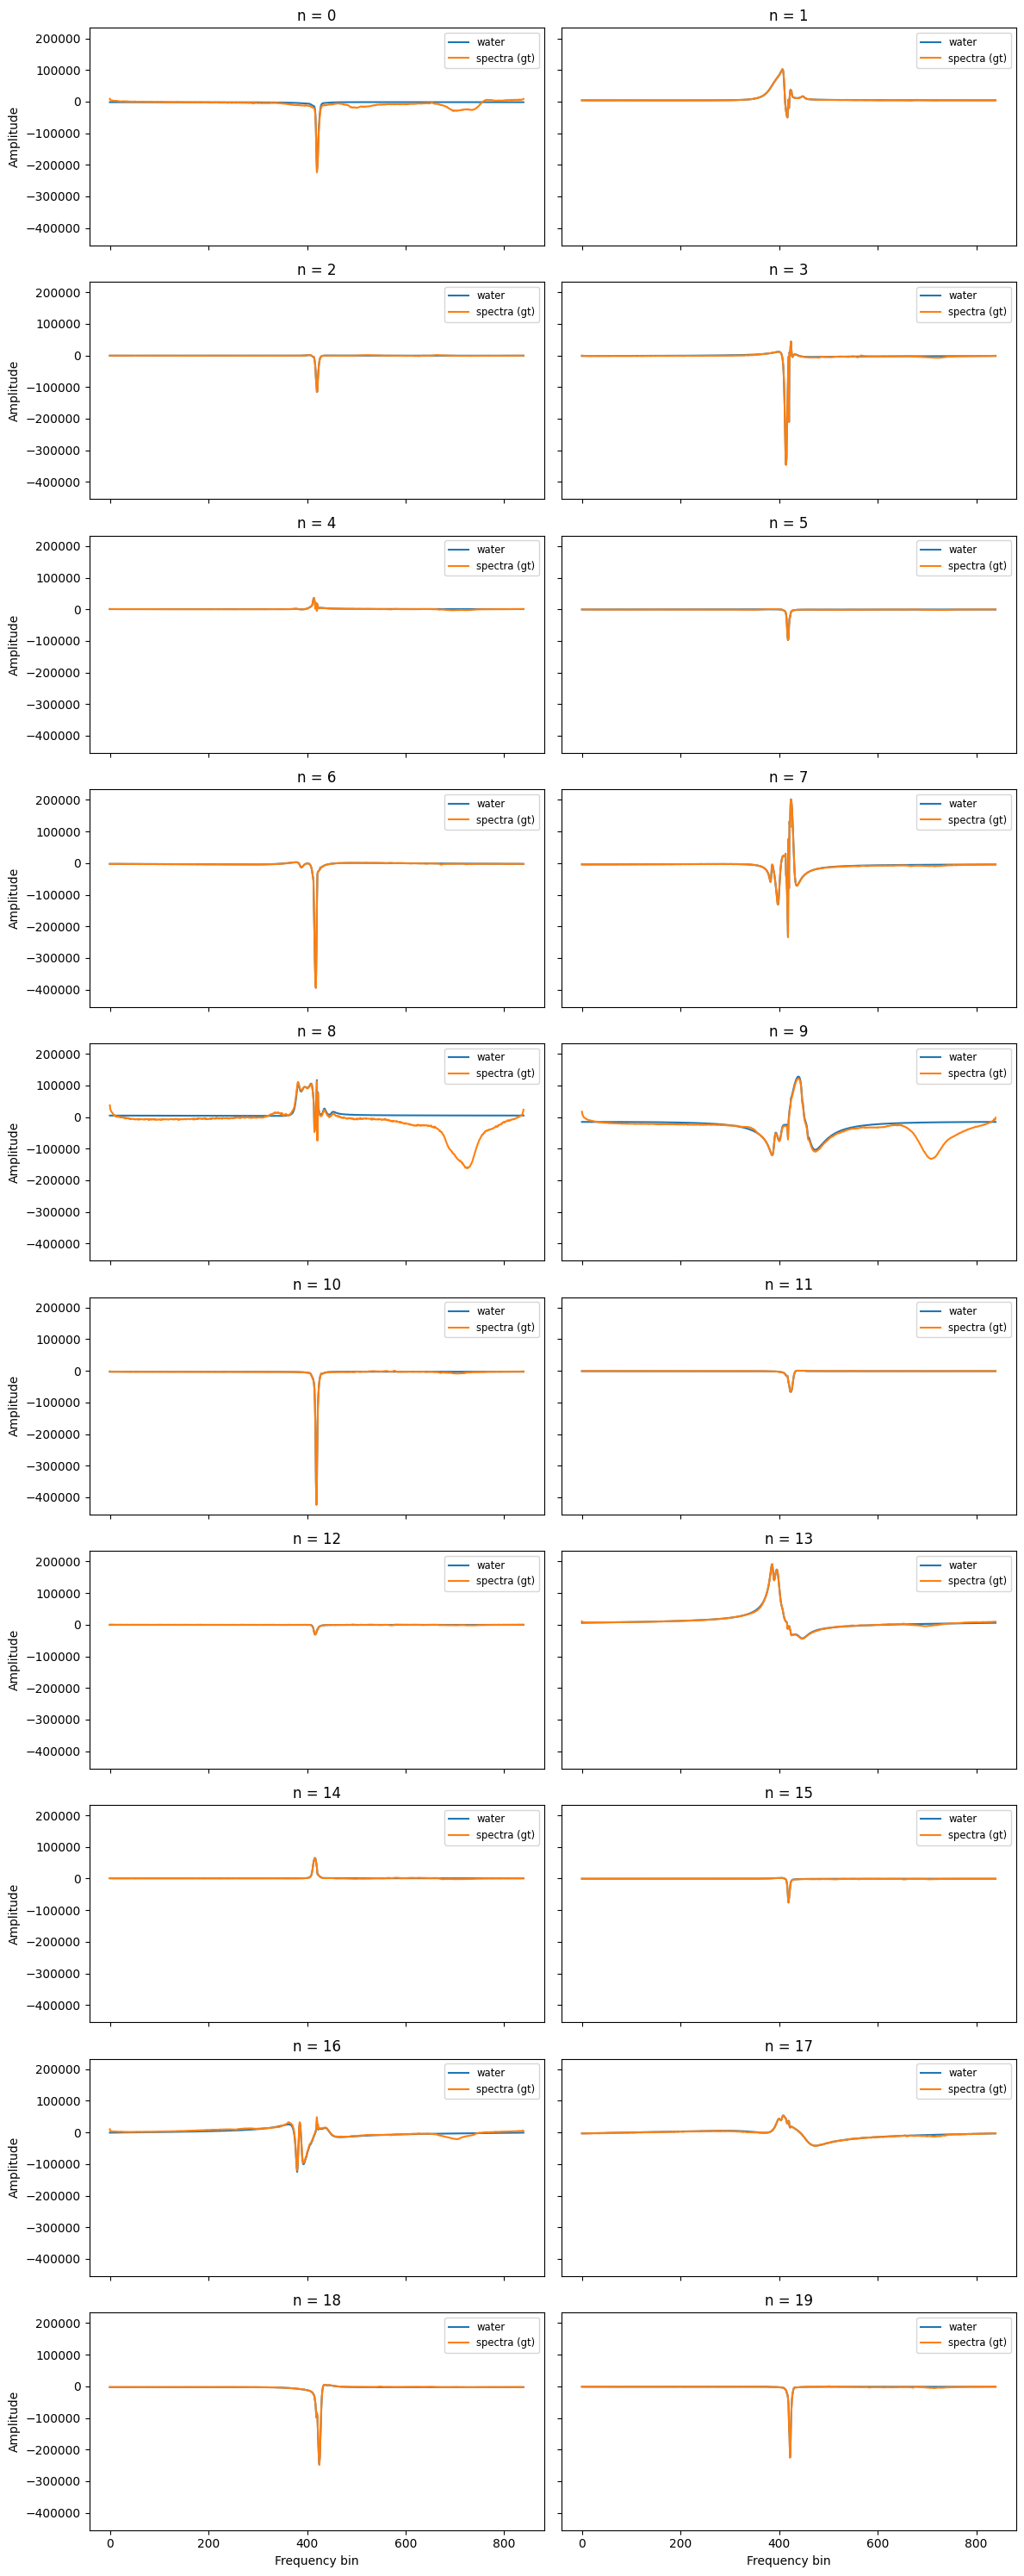

In [4]:
import numpy as np
import matplotlib.pyplot as plt
file_path = 'data/Vol6/TrainData/TrainData_v_1.0.h5'
with h5py.File(file_path, 'r') as hf:
    lipid        = hf['lipid'][:]        # shape (20,840), dtype complex128
    lipid_proj   = hf['lipid_proj'][:]   # shape (20,840), dtype complex128
    lipid_projOP = hf['lipid_projOP'][:] # shape (840,840), dtype complex128
    metab        = hf['metab'][:]        # shape (20,840), dtype complex128
    spectra      = hf['spectra'][:]      # shape (20,840), dtype complex128
    water        = hf['water'][:]        # shape (20,840), dtype complex128

# assume lipid, lipid_proj are already in memory, shape (20, N)
fig, axes = plt.subplots(10, 2, figsize=(12, 30), sharex=True, sharey=True)

for n in range(20):
    row, col = divmod(n, 2)
    ax = axes[row, col]
    x = np.arange(lipid.shape[1])
    ax.plot(np.real(water[n,:]), label='water')
    ax.plot(np.real(spectra[n,:]),      label='spectra (gt)')
    ax.set_title(f'n = {n}')
    if row == 9:  ax.set_xlabel('Frequency bin')
    if col == 0:  ax.set_ylabel('Amplitude')
    ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

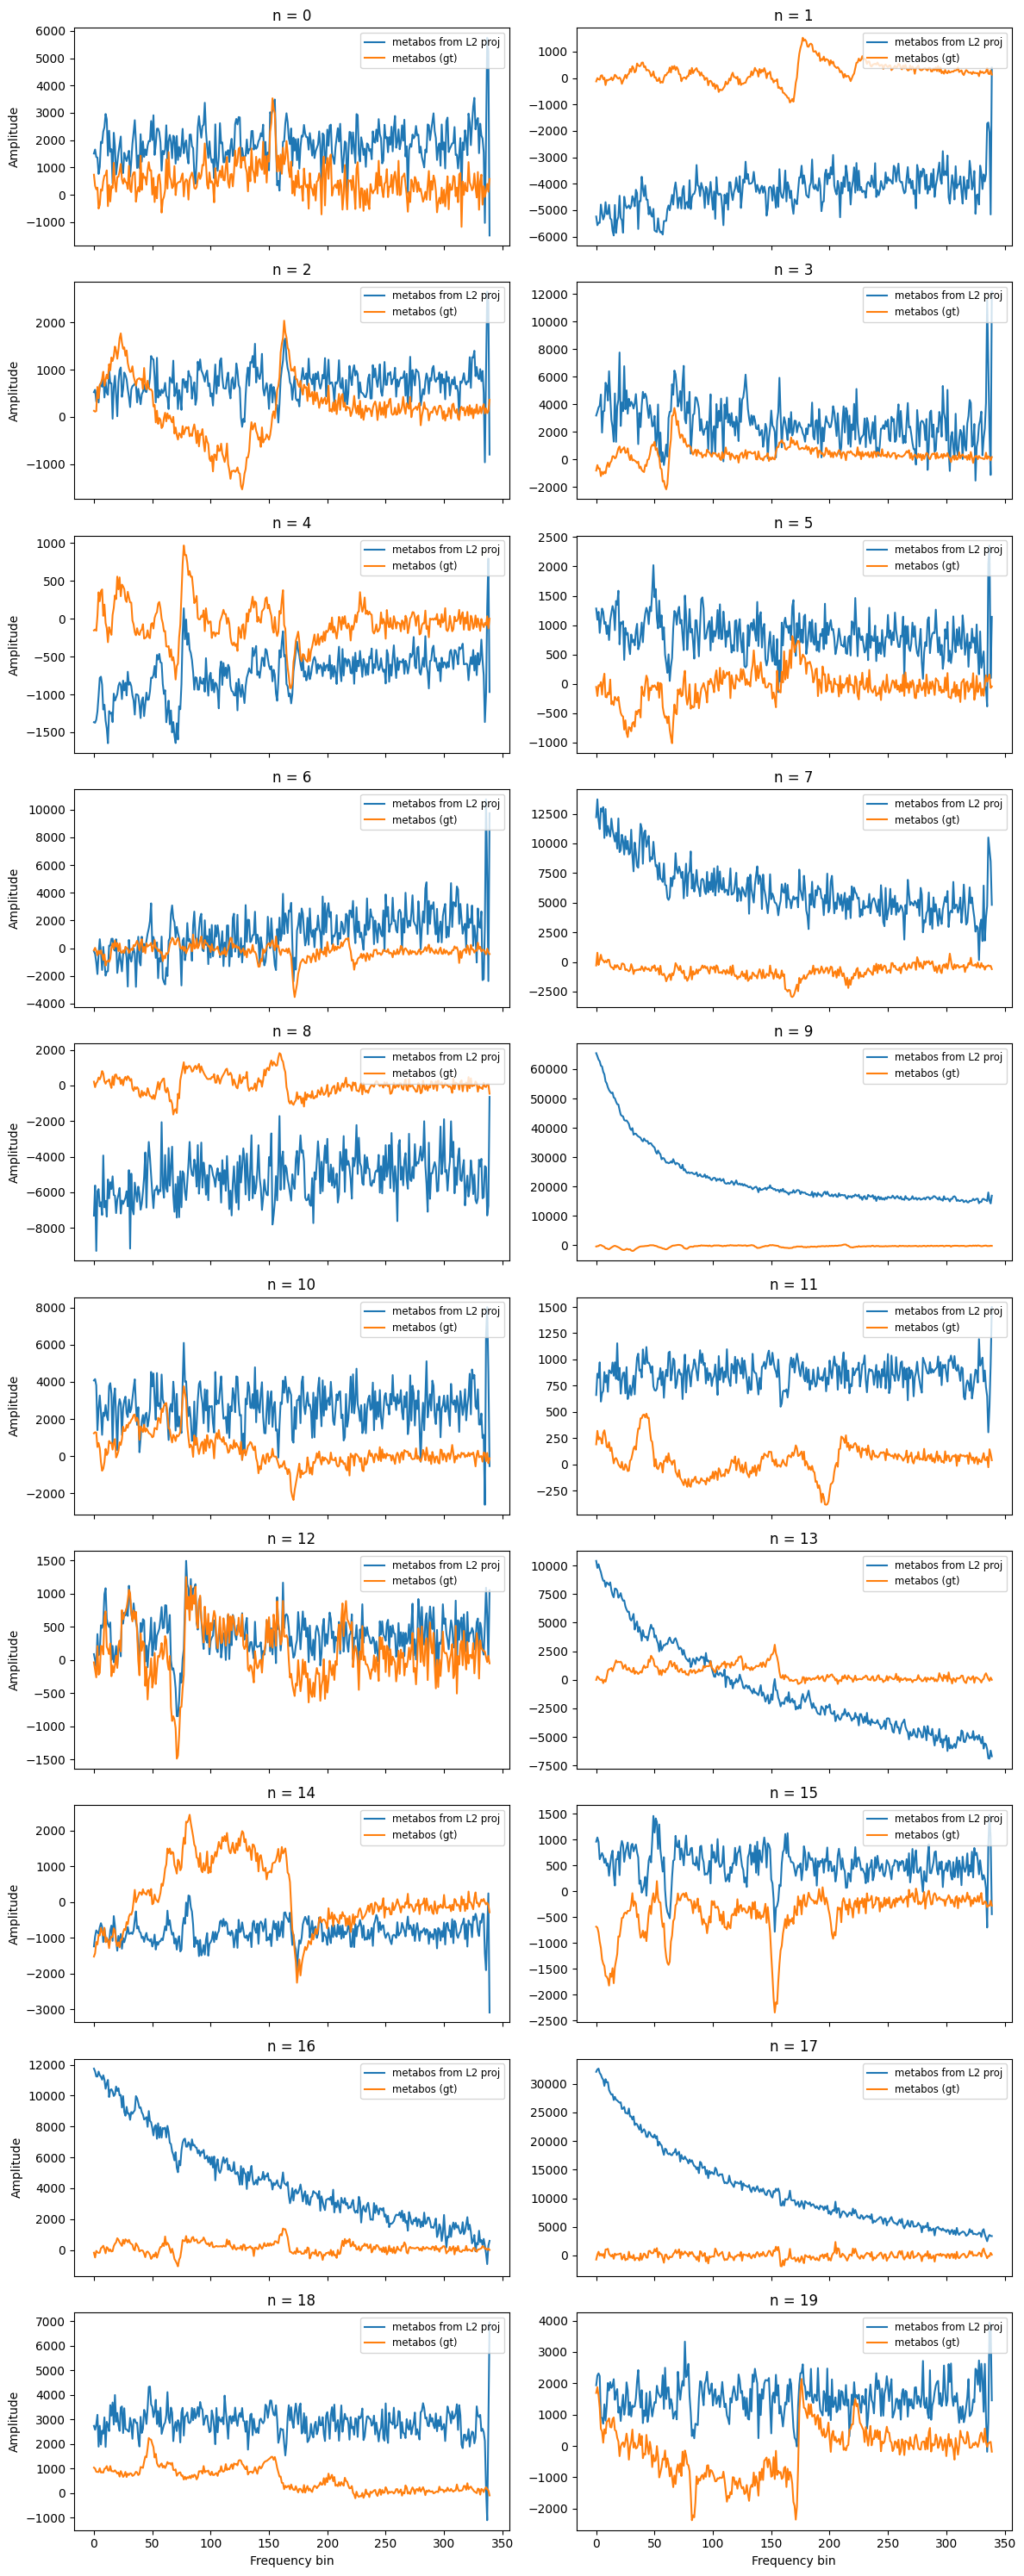

In [6]:
start = 500
# assume lipid, lipid_proj are already in memory, shape (20, N)
fig, axes = plt.subplots(10, 2, figsize=(12, 30), sharex=True, sharey=False)

for n in range(20):
    row, col = divmod(n, 2)
    ax = axes[row, col]
    x = np.arange(lipid.shape[1])
    ax.plot(np.real(spectra[n,start:]-water[n,start:]-lipid_proj[n,start:]), label='metabos from L2 proj')
    ax.plot(np.real(metab[n,start:]),      label='metabos (gt)')
    ax.relim() 
    ax.autoscale_view()

    ax.set_title(f'n = {n}')
    if row == 9:  ax.set_xlabel('Frequency bin')
    if col == 0:  ax.set_ylabel('Amplitude')
    ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()